In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter

In [32]:
df = pd.read_csv("../data/ltv_cleaned_data.csv", index_col=0)

df[["event_timestamp", "first_purchase_time", "cohort_week"]] = df[
    ["event_timestamp", "first_purchase_time", "cohort_week"]
].apply(pd.to_datetime)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200 entries, 0 to 1199
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              1200 non-null   object        
 1   event_timestamp      1200 non-null   datetime64[ns]
 2   first_purchase_time  1200 non-null   datetime64[ns]
 3   cohort_week          1200 non-null   datetime64[ns]
 4   product_id           1200 non-null   object        
 5   lifetime_months      1200 non-null   int64         
 6   price                1200 non-null   float64       
 7   frequency            1200 non-null   int64         
 8   revenue              1200 non-null   float64       
dtypes: datetime64[ns](3), float64(2), int64(2), object(2)
memory usage: 93.8+ KB


In [33]:
total_users = pd.Series(df["user_id"].unique())

total_users.shape

(561,)

In [34]:
max_lifetime_per_user = df.groupby("user_id")["lifetime_months"].max()

max_lifetime_per_user.describe()

count    561.000000
mean       1.210339
std        1.948067
min        0.000000
25%        0.000000
50%        0.000000
75%        2.000000
max        7.000000
Name: lifetime_months, dtype: float64

In [35]:
user_attributes_df = (
    df.groupby("user_id")
    .agg(
        {
            "lifetime_months": "max",
            "first_purchase_time": "first",
            "cohort_week": "first",  # Similarly, 'first' assumes all entries per user are the same
        }
    )
    .reset_index()
)

user_attributes_df.columns = [
    "user_id",
    "max_lifetime_months",
    "first_purchase_time",
    "cohort_week",
]

user_attributes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   user_id              561 non-null    object        
 1   max_lifetime_months  561 non-null    int64         
 2   first_purchase_time  561 non-null    datetime64[ns]
 3   cohort_week          561 non-null    datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 17.7+ KB


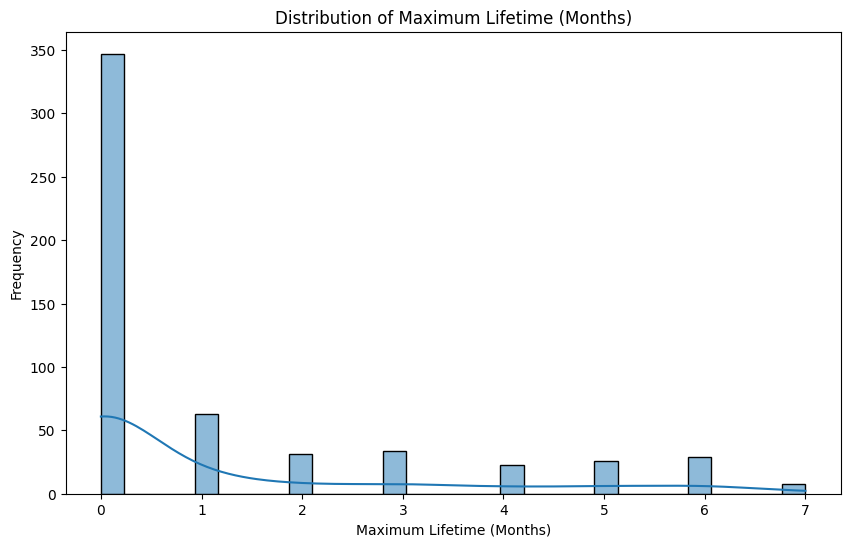

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(max_lifetime_per_user, bins=30, kde=True)
plt.title("Distribution of Maximum Lifetime (Months)")
plt.xlabel("Maximum Lifetime (Months)")
plt.ylabel("Frequency")
plt.show()

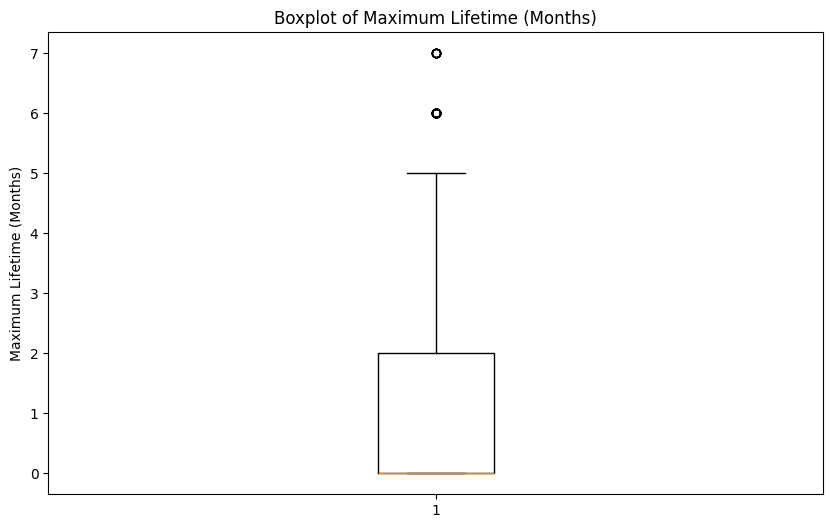

In [37]:
# Boxplot to identify outliers
plt.figure(figsize=(10, 6))
plt.boxplot(max_lifetime_per_user)
plt.title("Boxplot of Maximum Lifetime (Months)")
plt.ylabel("Maximum Lifetime (Months)")
plt.show()

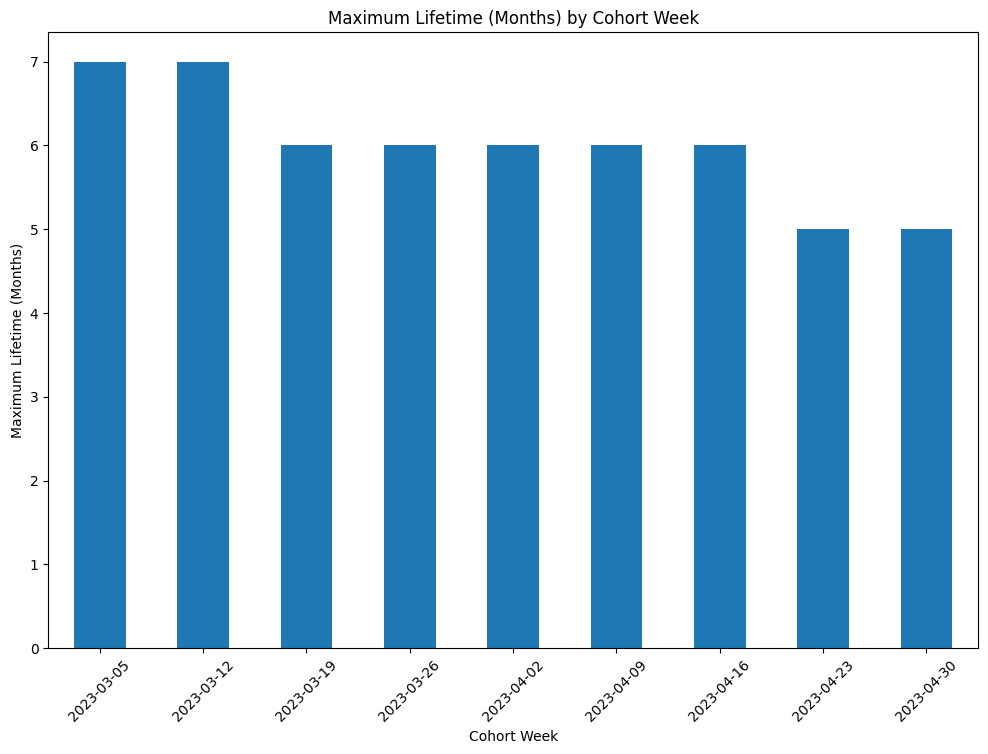

In [38]:
df["cohort_week"] = df["cohort_week"].dt.strftime("%Y-%m-%d")
max_lifetime_per_cohort = df.groupby("cohort_week")["lifetime_months"].max()

plt.figure(figsize=(12, 8))
max_lifetime_per_cohort.plot(kind="bar")
plt.title("Maximum Lifetime (Months) by Cohort Week")
plt.xlabel("Cohort Week")
plt.ylabel("Maximum Lifetime (Months)")
plt.xticks(rotation=45)
plt.show()

In [39]:
# Assume that if a user has no purchases for a long period, they have churned
# Define a churn threshold, e.g., a user who hasn't made a purchase in 6 months is considered churned
CHURN_THRESHOLD = 180  # days

survival_df = pd.DataFrame()
survival_df.loc[:, "user_id"] = df.loc[:, "user_id"]
survival_df.loc[:, "event_timestamp"] = df.loc[:, "event_timestamp"]

survival_df["last_purchase"] = df.groupby("user_id")["event_timestamp"].transform("max")
survival_df["is_churned"] = (
    pd.to_datetime("today") - survival_df["last_purchase"]
).dt.days > CHURN_THRESHOLD

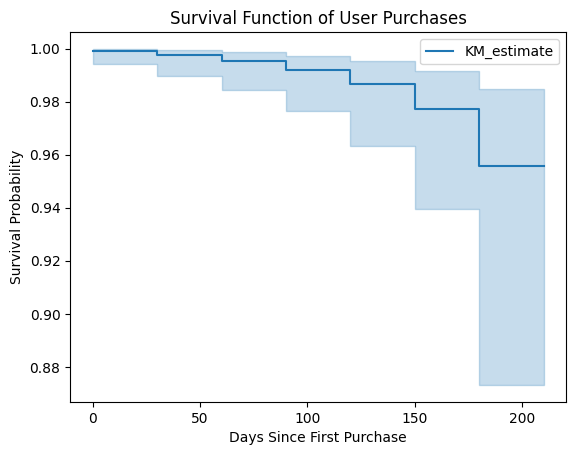

In [40]:
# Create a 'duration' and 'observed' column for survival analysis
survival_df["duration"] = (df["event_timestamp"] - df["first_purchase_time"]).dt.days
survival_df["observed"] = ~survival_df[
    "is_churned"
]  # True if the event is observed (not churned)

# Fit the Kaplan-Meier estimator
kmf = KaplanMeierFitter()
kmf.fit(durations=survival_df["duration"], event_observed=survival_df["observed"])

kmf.plot_survival_function()
plt.title("Survival Function of User Purchases")
plt.xlabel("Days Since First Purchase")
plt.ylabel("Survival Probability")
plt.show()

# The Shaded Area (Confidence Interval)

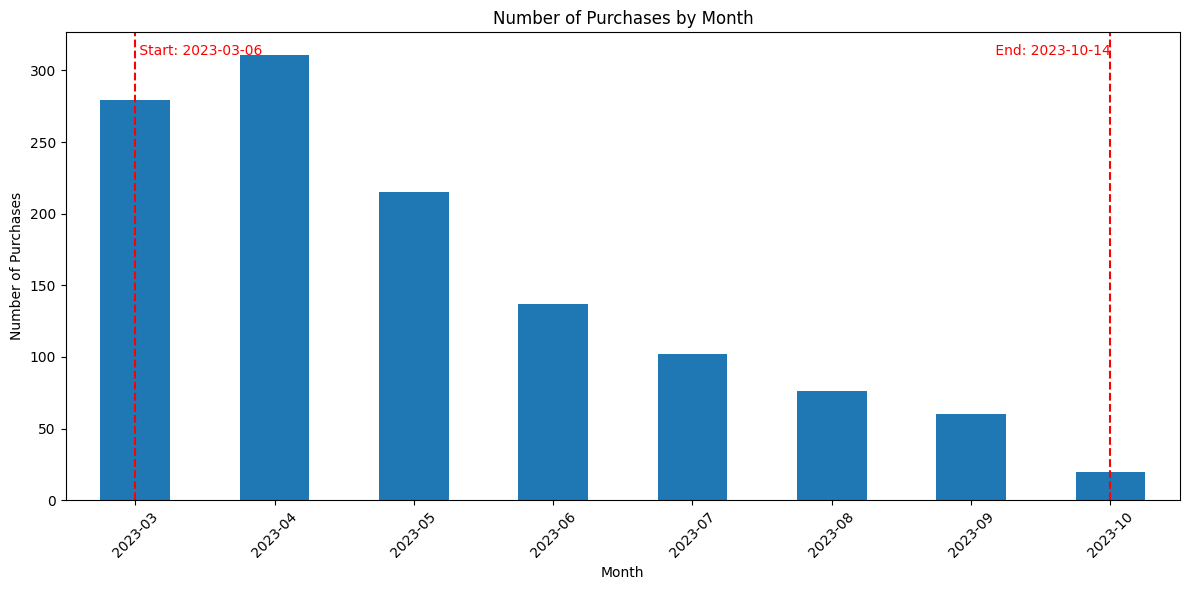

In [41]:
# Create a new column that just contains the year and month
df["year_month"] = df["event_timestamp"].dt.to_period("M")

# Group by the new column and count the number of purchases
monthly_purchases = df.groupby("year_month").size()

# Plot the data
plt.figure(figsize=(12, 6))
monthly_purchases.plot(kind="bar")
plt.title("Number of Purchases by Month")
plt.xlabel("Month")
plt.ylabel("Number of Purchases")

# Highlight the start and end periods as partial data
plt.axvline(x=0, color="red", linestyle="--")  # Start date line
plt.axvline(x=len(monthly_purchases) - 1, color="red", linestyle="--")  # End date line

# Annotate the start and end periods
plt.text(0, max(monthly_purchases), " Start: 2023-03-06", color="red")
plt.text(
    len(monthly_purchases) - 1,
    max(monthly_purchases),
    " End: 2023-10-14",
    color="red",
    ha="right",
)


plt.xticks(rotation=45)
plt.tight_layout()  # This will ensure that the labels don't get cut off
plt.show()

# first event_timestamp == 2023-03-06 04:55:30
# last_event_timestamp == 2023-10-14 06:00:06

  cohort_week  revenue
0  2023-03-05  2460.53
1  2023-03-12  1873.50
2  2023-03-19  2198.24
3  2023-03-26  1511.29
4  2023-04-02   961.73
5  2023-04-09  1373.90
6  2023-04-16  1186.55
7  2023-04-23  1536.27
8  2023-04-30  1885.99


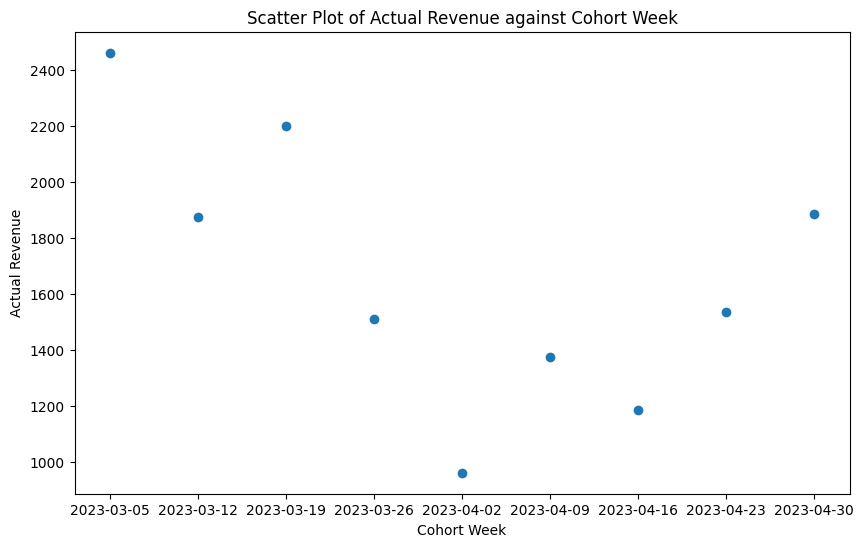

In [55]:
cohort_revenue_df = (
    df.groupby("user_id").first().groupby("cohort_week")["revenue"].sum().reset_index()
)

plt.figure(figsize=(10, 6))
plt.scatter(cohort_revenue_df["cohort_week"], cohort_revenue_df["revenue"])
plt.title("Scatter Plot of Actual Revenue against Cohort Week")
plt.xlabel("Cohort Week")
plt.ylabel("Actual Revenue")
plt.show()